# Imports

In [1]:
%pip install -r requirements3_11.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import rdflib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import random

# Files

In [3]:
gene_ontology_file_path = '../DB/go.owl'
protein_file_path = '../DB/9606.protein.enrichment.terms.v12.0.txt'
protein_links_file_path = '../DB/9606.protein.links.v12.0.txt'
protein_full_links_file_path = '../DB/9606.protein.links.detailed.v12.0.txt'
semantic_similarity_file_path = '../DB/NegativeSamplesUncertainty.csv'
gene_ontology_annotated_file_path = '../DB/go_annotated.owl'

# Creating the Knowledge graph

In [4]:
g = rdflib.Graph()
g.parse(gene_ontology_annotated_file_path, format = 'xml');

prots = pd.read_csv(protein_file_path, sep='\t', header=0)
prots = prots[prots['term'].str.startswith('GO:')].reset_index(drop=True)
prots = prots['#string_protein_id'].unique().tolist()

g = rdflib.Graph()
g.parse(gene_ontology_file_path, format = 'xml');

prots = []

with open(protein_file_path , 'r') as prot_annot:
    prot_annot.readline()
    for line in prot_annot:
        elements_annot = line.split('\t')
        id_prot, GO_term = elements_annot[0], elements_annot[2]
        if GO_term.startswith('GO:') :
            url_GO_term = 'http://purl.obolibrary.org/obo/GO_' + GO_term.split(':')[1]
            url_prot = 'https://string-db.org/network/' + id_prot
            if id_prot not in prots:
                prots.append(id_prot)
            g.add((rdflib.term.URIRef(url_prot), rdflib.term.URIRef('http://purl.obolibrary.org/obo/go.owl#has_function') , rdflib.term.URIRef(url_GO_term)))

# Distribution of Confidence

In [5]:
data_full = pd.read_csv(protein_full_links_file_path, sep=" ", header=0)
data_full = data_full[data_full["protein1"].isin(prots) & data_full["protein2"].isin(prots)]

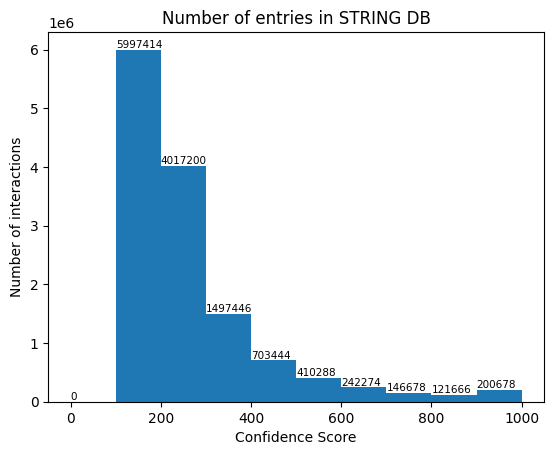

In [6]:
# Create a histogram and get the patches
counts, bins, patches = plt.hist(data_full['combined_score'], bins=10, bottom=list(range(0,1000,100)), range=(0,1000))

# Set the title and labels
plt.title('Number of entries in STRING DB')
plt.xlabel('Confidence Score')
plt.ylabel('Number of interactions')

# Annotate histogram with the number of data points in each bin
for count, bin, patch in zip(counts, bins, patches):
    height = patch.get_height()
    plt.text(bin, height, str(int(count)), va='bottom', fontsize=7.5)

plt.show()

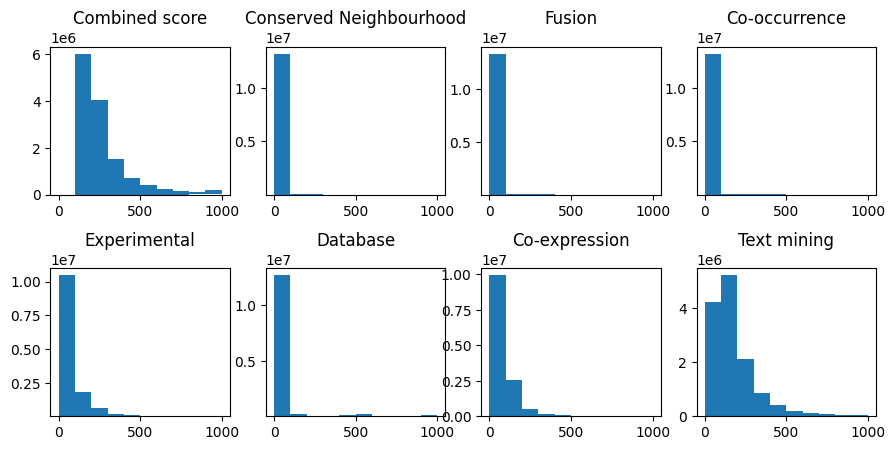

In [7]:
fig, axs = plt.subplots(2, 4)
axs[0, 0].hist(data_full['combined_score'],bins=10,bottom=list(range(0,1000,100)),range=(0,1000));
axs[0, 0].set_title('Combined score', y=1.1)  # Increase the y parameter to move the title up
axs[0, 1].hist(data_full['neighborhood'],bins=10,bottom=list(range(0,1000,100)),range=(0,1000));
axs[0, 1].set_title('Conserved Neighbourhood', y=1.1)
axs[0, 2].hist(data_full['fusion'],bins=10,bottom=list(range(0,1000,100)),range=(0,1000));
axs[0, 2].set_title('Fusion', y=1.1)
axs[0, 3].hist(data_full['cooccurence'],bins=10,bottom=list(range(0,1000,100)),range=(0,1000));
axs[0, 3].set_title('Co-occurrence', y=1.1)
axs[1, 0].hist(data_full['experimental'],bins=10,bottom=list(range(0,1000,100)),range=(0,1000));
axs[1, 0].set_title('Experimental', y=1.1)
axs[1, 1].hist(data_full['database'],bins=10,bottom=list(range(0,1000,100)),range=(0,1000));
axs[1, 1].set_title('Database', y=1.1)
axs[1, 2].hist(data_full['coexpression'],bins=10,bottom=list(range(0,1000,100)),range=(0,1000));
axs[1, 2].set_title('Co-expression', y=1.1)
axs[1, 3].hist(data_full['textmining'],bins=10,bottom=list(range(0,1000,100)),range=(0,1000));
axs[1, 3].set_title('Text mining', y=1.1);

plt.subplots_adjust(left=0.01, right=1.3, hspace=0.5)

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

In [9]:
negatives = pd.read_csv(semantic_similarity_file_path, header=0, index_col=0,dtype={'Entity A': str, 'Entity B': str}).sort_values(by=['BMA_Seco2004'], ascending=True).reset_index()
negatives['BMA_Seco2004'] = (1-negatives['BMA_Seco2004']) * 1000
negatives['Entity A'] = 'https://string-db.org/network/9606.ENSP' + negatives['Entity A']
negatives['Entity B'] = 'https://string-db.org/network/9606.ENSP' + negatives['Entity B']

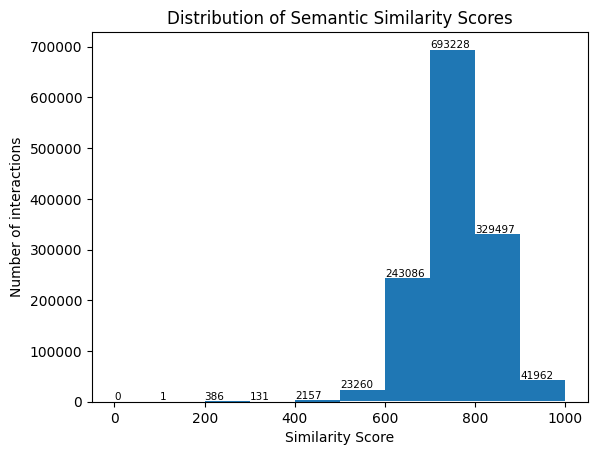

In [10]:
# Create a histogram and get the patches
counts, bins, patches = plt.hist(negatives['BMA_Seco2004'], bins=10, bottom=list(range(0,1000,100)), range=(0,1000))

# Set the title and labels
plt.title('Distribution of Semantic Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Number of interactions')

# Annotate histogram with the number of data points in each bin
for count, bin, patch in zip(counts, bins, patches):
    height = patch.get_height()
    plt.text(bin, height, str(int(count)), va='bottom', fontsize=7.5)

plt.show()

# Creating thresholds

In [11]:
# Thresholds for the whole dataset

# data8 = data_full.where(data_full['combined_score']>800).dropna().reset_index(drop=True)
# data6 = data_full.where(data_full['combined_score']>600).dropna().reset_index(drop=True)
# data4 = data_full.where(data_full['combined_score']>400).dropna().reset_index(drop=True)
# data2 = data_full.where(data_full['combined_score']>200).dropna().reset_index(drop=True)
# dataSample = data_full

# Thresholds for fixed size sampling (1000 samples)

# data8 = data_full.where(data_full['combined_score']>800).dropna().reset_index(drop=True).sample(n=1000, random_state=42)
# data6 = data_full.where(data_full['combined_score']>600).dropna().reset_index(drop=True).sample(n=1000,random_state=42)
# data4 = data_full.where(data_full['combined_score']>400).dropna().reset_index(drop=True).sample(n=1000,random_state=42)
# data2 = data_full.where(data_full['combined_score']>200).dropna().reset_index(drop=True).sample(n=1000,random_state=42)
# dataSample = data_full.sample(n=1000,random_state=42)

# Thresholds for fraction sampling (10% of the data)

data8 = data_full.where(data_full['combined_score']>800).dropna().reset_index(drop=True).sample(frac=0.1, random_state=42)
data6 = data_full.where(data_full['combined_score']>600).dropna().reset_index(drop=True).sample(frac=0.1,random_state=42)
data4 = data_full.where(data_full['combined_score']>400).dropna().reset_index(drop=True).sample(frac=0.1,random_state=42)
data2 = data_full.where(data_full['combined_score']>200).dropna().reset_index(drop=True).sample(frac=0.1,random_state=42)
dataSample = data_full.sample(frac=0.1,random_state=42)


# Thresholds for uniform sampling

# select = []
# for N in range(1000):
#    ind = int(N*len(data8)/1000)
#    select.append(ind)
# data8 = data8.loc[select]
# select = []
# for N in range(1000):
#    ind = int(N*len(data6)/1000)
#    select.append(ind)
# data6 = data6.loc[select]
# select = []
# for N in range(1000):
#    ind = int(N*len(data4)/1000)
#    select.append(ind)
# data4 = data4.loc[select]
# select = []
# for N in range(1000):
#    ind = int(N*len(data8)/1000)
#    select.append(ind)
# data2 = data2.loc[select]
# select = []
# for N in range(1000):
#    ind = int(N*len(dataSample)/1000)
#    select.append(ind)
# dataSample = dataSample.reset_index(drop=True).loc[select]


# Thresholds for training with data above 800 and testing with data below 800
# train = data_full.where(data_full['combined_score']>800).dropna().reset_index(drop=True).sample(frac=0.1,random_state=42)
# test = data_full.where(data_full['combined_score']<800).dropna().reset_index(drop=True).sample(frac=0.1,random_state=42)

all_negative_pairs_prots = []
# Without semantic similarity
# pairs_prots_STRING = []
# for d in data_full.values:
#     pairs_prots_STRING.append(('https://string-db.org/network/' + d[0],'https://string-db.org/network/' + d[1], 1))
# pairs_prots_STRING = set(pairs_prots_STRING)
# Creating a list of all proteins
# prots_links = ['https://string-db.org/network/' + prot for prot in prots]
# for prot in prots_links:
#     for prot2 in prots_links:
#         if (prot,prot2,1) in pairs_prots_STRING:
#             continue
#         elif prot != prot2:
#             all_negative_pairs_prots.append((prot,prot2,0))

# del pairs_prots_STRING
# del prots_links

# With semantic similarity
for n in negatives.values:
    all_negative_pairs_prots.append((n[1],n[2],0))

del data_full
del negatives
del prots

# Pipeline

# Imports
from pyrdf2vec.graphs import kg
from pyrdf2vec.rdf2vec import RDF2VecTransformer
from pyrdf2vec.embedders import Word2Vec
from pyrdf2vec.samplers import UniformSampler, ObjFreqSampler, PredFreqSampler
from pyrdf2vec.walkers import RandomWalker, WeisfeilerLehmanWalker, WalkletWalker

# Defining rdf2vec paramenters
vector_size = 200
n_walks = 100
type_word2vec = 'skip-gram'
walk_depth = 4
walker_type = 'wl'
sampler_type = 'uniform'

# Creating a pyrdf2vec graph
# Creating a pyrdf2vec graph
# g_pyrdf2vec = kg.KG(mul_req=False)
# for (s, p, o) in g:
#     s_v = Vertex(str(s))
#     o_v = Vertex(str(o))
#     p_v = Vertex(str(p), predicate=True, vprev=s_v, vnext=o_v)
#     g_pyrdf2vec.add_vertex(s_v)
#     g_pyrdf2vec.add_vertex(p_v)
#     g_pyrdf2vec.add_vertex(o_v)
#     g_pyrdf2vec.add_edge(s_v, p_v)
#     g_pyrdf2vec.add_edge(p_v, o_v)

g_pyrdf2vec = kg.KG("../DB/go_annotated.owl", mul_req=False)

# Defining the word2vec strategy
if type_word2vec == 'CBOW':
    sg_value = 0
elif type_word2vec == 'skip-gram':
    sg_value = 1

# Defining sampling strategy
if sampler_type.lower() == 'uniform':
    sampler = UniformSampler()
elif sampler_type.lower() == 'predfreq':
    sampler = PredFreqSampler()
elif sampler_type.lower() == 'objfreq':
    sampler = ObjFreqSampler()

# Defining walker strategy
if walker_type.lower() == 'random':
    walker = RandomWalker(depth=walk_depth, walks_per_graph=n_walks, sampler = sampler, n_jobs = -1)
elif walker_type.lower() == 'wl':
    walker = WeisfeilerLehmanWalker(depth=walk_depth, walks_per_graph=n_walks, sampler = sampler, n_jobs = -1)
#   walker = WLWalker(max_depth=walk_depth, max_walks=n_walks, sampler = sampler)
elif walker_type.lower() == 'walklet':
    walker = WalkletWalker(depth=walk_depth, walks_per_graph=n_walks, sampler = sampler, n_jobs = -1 )

# testing RDF2Vec embeddings
transformer = RDF2VecTransformer(Word2Vec(size=vector_size, sg=sg_value), walkers=[walker])

# Generating the embeddings
embeddings = transformer.fit_transform(g_pyrdf2vec, prots)
dict_embeddings = {prots[i]: embeddings[i] for i in range(len(prots))}
dict_embeddings.to_csv('DB/embeddings.csv', index=True)

In [13]:
embedCSV = pd.read_csv('../DB/embeddings.csv',index_col=0)
embeddings_array = np.array(list(embedCSV.values))
dict_embeddings = {embedCSV.index[i]: embeddings_array[i] for i in range(len(embeddings_array))}
vector_size = embedCSV.shape[1]

In [14]:
random.seed(42)

f1_results = {} # list of f1 results

for i in range(800, -1, -200):
    if i == 800:
        data = data8
    elif i == 600:
        data = data6
    elif i == 400:
        data = data4
    elif i == 200:
        data = data2
    elif i == 0:
        data = dataSample

    pairs_prots = []
    for d in data.values:
        pairs_prots.append(('https://string-db.org/network/' + d[0],'https://string-db.org/network/' + d[1], 1))

    # Withou semantic similarity
    #negative_pairs_prots = random.sample(all_negative_pairs_prots, len(pairs_prots))
        
    # With semantic similarity
    negative_pairs_prots = all_negative_pairs_prots[:len(pairs_prots)]    

    # Generating pair representations using hadamard operator # other possibilities are concatenation, wl-1 or wl-2
    X, y = [], []
    for prot1, prot2, label in pairs_prots:
        emb_prot1 = dict_embeddings[prot1].reshape(1, vector_size)
        emb_prot2 = dict_embeddings[prot2].reshape(1, vector_size)
        hada = np.multiply(emb_prot1, emb_prot2)
        X.append(hada.tolist()[0])
        y.append(int(label))

    for prot1, prot2, label in negative_pairs_prots:
        emb_prot1 = dict_embeddings[prot1].reshape(1, vector_size)
        emb_prot2 = dict_embeddings[prot2].reshape(1, vector_size)
        hada = np.multiply(emb_prot1, emb_prot2)
        X.append(hada.tolist()[0])
        y.append(int(label))

    f1 = []

    # Creating training set and test set
    sss = StratifiedShuffleSplit(n_splits=10, random_state=42)
    X, y = np.array(X), np.array(y)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

        # Training Random Forest classifier
        rf_model = RandomForestClassifier(n_jobs=-1, random_state=42)
        rf_model.fit(X_train, y_train)

        # Obtaining predictions
        pred_test = rf_model.predict(X_test)

        # Computing performance metrics
        weighted_avg_f1 = metrics.f1_score(y_test, pred_test, average='weighted')
        f1.append(weighted_avg_f1)
    
    f1_mean = np.mean(f1)
    
    f1_results[i] = f1_mean

    # Printing performance metrics
    print('Weighted Average F-measure for ' + str(i) + ' or more confidence score= ' + str(f1_mean))

Weighted Average F-measure for 800 or more confidence score= 0.9784156209609749


KeyboardInterrupt: 

# F-measure Analysis

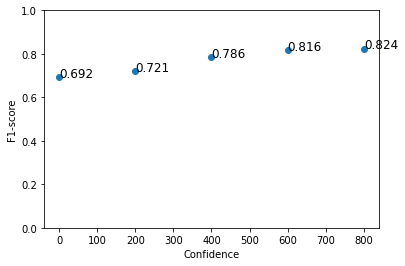

In [ ]:
f1_x = list(f1_results.keys())
f1_y = list(f1_results.values())

plt.scatter(f1_x,f1_y)
plt.xlabel('Confidence')
plt.ylabel('F1-score')
plt.ylim(0,1)
plt.title('F1-score vs Confidence')

#use for loop to add annotations to each point in plot 
for i, txt in enumerate(f1_y):
    plt.annotate(round(txt,3), (f1_x[i]+.25, f1_y[i]), fontsize=12)

plt.show()